In [1]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import decode_predictions
from keras.models import Model, load_model
import keras.backend as K

import model as tcav_model
import tcav as tcav
import utils as utils
import activation_generator as act_gen
import tensorflow as tf
import utils_plot as utils_plot


from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from numpy.linalg import norm

import pickle
from bunch import bunchify

import cav as cav

from os import listdir
from os.path import isfile, join
import operator
from PIL import Image
from keras.preprocessing import image



Using TensorFlow backend.


In [2]:
model = None
model = load_model('v3_model.h5')

/Users/tyler/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
sess = K.get_session()

endpoints_v3 = dict(
    input=model.inputs[0].name,
    input_tensor=model.inputs[0],
    logit=model.outputs[0].name,
    prediction=model.outputs[0].name,
    prediction_tensor=model.outputs[0],
)

tf.logging.set_verbosity(0)

label_path = '/Users/tyler/Desktop/dissertation/programming/tcav/labels/labels.txt'

mymodel = tcav_model.KerasModelWrapper(sess, 
        label_path, [299, 299, 3], endpoints_v3, 
        'InceptionV3_public', (-1, 1))

## Generate CAV

In [10]:
#act_generator = None

working_dir = '/Users/tyler/Desktop/dissertation/programming/tcav_on_azure'
activation_dir =  working_dir + '/activations/'
cav_dir = working_dir + '/cavs/'
source_dir = working_dir + '/concepts'

target = 'zebra'
concepts = ['striped_texture'] 
#concepts = ['dotted']   

bottlenecks = ['mixed5']

alphas = [0.1]

act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=200)


mytcav = tcav.TCAV(sess,
        target, concepts, bottlenecks,
        act_generator, alphas,
        cav_dir = cav_dir,
        num_random_exp=1)

INFO:tensorflow:mixed5 ['striped_texture', 'random500_0'] zebra 0.1
INFO:tensorflow:TCAV will 1 params


In [11]:
tf.logging.set_verbosity(1)
results = mytcav.run(run_parallel=False)

INFO:tensorflow:running 1 params
INFO:tensorflow:Running param 0 of 1
INFO:tensorflow:running zebra ['striped_texture', 'random500_0']
['striped_texture', 'random500_0', 'zebra']
INFO:tensorflow:/Users/tyler/Desktop/dissertation/programming/tcav_on_azure/activations/acts_striped_texture_mixed5 does not exist, Making one...
INFO:tensorflow:/Users/tyler/Desktop/dissertation/programming/tcav_on_azure/activations/acts_random500_0_mixed5 does not exist, Making one...
INFO:tensorflow:/Users/tyler/Desktop/dissertation/programming/tcav_on_azure/activations/acts_zebra_mixed5 does not exist, Making one...
INFO:tensorflow:Training CAV ['striped_texture', 'random500_0'] - mixed5 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:using new version


/Users/tyler/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


INFO:tensorflow:acc per class {'striped_texture': 0.8235294117647058, 'random500_0': 1.0, 'overall': 0.9090909090909091}
INFO:tensorflow:/Users/tyler/Desktop/dissertation/programming/tcav_on_azure/cavs/striped_texture-random500_0-mixed5-linear-0.1_test.pkl
INFO:tensorflow:did save save_path_lin_sep
INFO:tensorflow:Done running 1 params. Took 153.66841387748718 seconds...


In [12]:
pwd

'/Users/tyler/Desktop/dissertation/programming/tcav_on_azure'

In [13]:
results

[{'cav_key': 'striped_texture-random500_0-mixed5-linear-0.1',
  'cav_concept': 'striped_texture',
  'target_class': 'zebra',
  'i_up': 0.59,
  'val_directional_dirs_abs_mean': 0.012039715471921775,
  'val_directional_dirs_mean': -0.0029314586721564295,
  'val_directional_dirs_std': 0.026342787611832834,
  'note': 'alpha_0.1 ',
  'alpha': 0.1,
  'bottleneck': 'mixed5'}]

## Load CAV

In [14]:
source_dir = '/Users/tyler/Desktop/dissertation/programming/tcav/cavs/'

cav_path = source_dir + 'striped_texture-random500_0-mixed5-linear-0.1.pkl'
#cav_path = source_dir + 'striped-random500_0-mixed8-linear-0.1.pkl'

this_cav = cav.CAV.load_cav(cav_path)

In [16]:
#this_cav.cavs[0]

## Generate Activations

In [18]:
bottleneck = bottlenecks[0]
target_class = target


acts = act_generator.process_and_load_activations([bottleneck], concepts + [target_class])

act_striped = acts['striped_texture'][bottleneck]
act_zebra = acts['zebra'][bottleneck]

['striped_texture', 'zebra']
INFO:tensorflow:Loaded /Users/tyler/Desktop/dissertation/programming/tcav_on_azure/activations/acts_striped_texture_mixed5 shape (120, 17, 17, 768)
INFO:tensorflow:Loaded /Users/tyler/Desktop/dissertation/programming/tcav_on_azure/activations/acts_zebra_mixed5 shape (200, 17, 17, 768)


In [20]:
act_striped.shape

(120, 17, 17, 768)

In [21]:
import math
def cosine_similarity(v1,v2):
    "compute cosine similarity of v1 to v2: (v1 dot v2)/{||v1||*||v2||)"
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    return sumxy/math.sqrt(sumxx*sumyy)

In [40]:
#source_dir = '/Users/tyler/Desktop/dissertation/programming/tcav/cavs/'
path = 'activations/images_used_zebra.pkl'
with open(path, 'rb') as f:
    data = pickle.load(f)
image_list = data

## make dict
ranked = {}

# define cavs
striped_cav = this_cav.cavs[0]
striped_cav_2d = striped_cav.reshape(-1,1)

#image_list
for count, each in enumerate(image_list):
    
    demo_1 = acts['zebra']['mixed5'][count]
    demo_2d = demo_1.reshape(-1,1)
    
    cos = cosine_similarity(striped_cav_2d,demo_2d)
    
    ranked[each] = cos

In [41]:
## sort
sorted_rank = sorted(ranked.items(), key=operator.itemgetter(1),reverse=True)

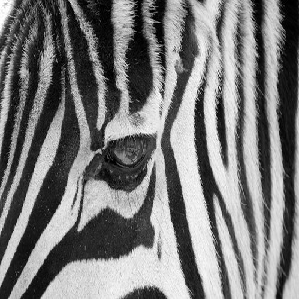

In [93]:
## show image
rank = 2

img_path, cos = sorted_rank[rank]
img = image.load_img(img_path, target_size=(299, 299))
img

In [39]:
image_list

['/Users/tyler/Desktop/dissertation/programming/tcav_on_azure/concepts/striped_texture/striped_0002.jpg',
 '/Users/tyler/Desktop/dissertation/programming/tcav_on_azure/concepts/striped_texture/striped_0029.jpg',
 '/Users/tyler/Desktop/dissertation/programming/tcav_on_azure/concepts/striped_texture/striped_0074.jpg',
 '/Users/tyler/Desktop/dissertation/programming/tcav_on_azure/concepts/striped_texture/striped_0109.jpg',
 '/Users/tyler/Desktop/dissertation/programming/tcav_on_azure/concepts/striped_texture/striped_0024.jpg',
 '/Users/tyler/Desktop/dissertation/programming/tcav_on_azure/concepts/striped_texture/striped_0025.jpg',
 '/Users/tyler/Desktop/dissertation/programming/tcav_on_azure/concepts/striped_texture/striped_0123.jpg',
 '/Users/tyler/Desktop/dissertation/programming/tcav_on_azure/concepts/striped_texture/striped_0094.jpg',
 '/Users/tyler/Desktop/dissertation/programming/tcav_on_azure/concepts/striped_texture/striped_0120.jpg',
 '/Users/tyler/Desktop/dissertation/programmin

In [ ]:
deriv = mytcav.get_directional_dir(
mymodel,
'zebra',
'striped_texture',
this_cav,
act_zebra
)

In [ ]:
len(deriv)

In [ ]:
dar = np.array(deriv)

In [ ]:
dar[dar > 0].shape

In [ ]:
dar[dar < 0].shape

In [ ]:
1 - 94/200

In [ ]:
working_dir = '/Users/tyler/Desktop/dissertation/programming/tcav/'

source_images = working_dir + 'concepts/zebra/'
images = [f for f in listdir(source_images) if isfile(join(source_images, f))]
total_images = len(images)

images.sort()
images = images[:200]


In [ ]:
len(images)

In [ ]:
this_d = {}

idx = 0
for d in deriv:
    this_d[idx] = d
    idx += 1

sorted_d = sorted(this_d.items(), key=operator.itemgetter(1),reverse=True)

In [ ]:
#this_d

In [ ]:
len(sorted_d)

In [ ]:
xx = 194
top = images[sorted_d[0][0]]
bottom = images[sorted_d[xx][0]]
this_img = bottom
#this_img = top

In [ ]:
img_path = source_images + this_img
img = image.load_img(img_path, target_size=(299, 299))

In [ ]:
img

## Load filenames

In [ ]:
#source_dir = '/Users/tyler/Desktop/dissertation/programming/tcav/cavs/'
path = 'files/f_used_10.pkl'

with open(path, 'rb') as f:
    data = pickle.load(f)
    
image_list = data

In [ ]:
image_list

In [ ]:
len(image_list)

In [ ]:
#sorted_d

In [ ]:
xx = 3
bottom = image_list[sorted_d[xx][0]]
this_img = bottom

img_path = this_img
img = image.load_img(img_path, target_size=(299, 299))

img

In [ ]:
class_acts = acts
for i in range(len(class_acts)):
    print(i)
    act = np.expand_dims(class_acts[i], 0)

In [ ]:
working_dir = '/Users/tyler/Desktop/dissertation/programming/tcav'
activation_dir =  working_dir + '/activations/'
cav_dir = working_dir + '/cavs/'
source_dir = working_dir + '/concepts'

target = 'zebra'
concepts = ['striped'] 
concepts = ['dotted']   

bottlenecks = ['mixed8']


alphas = [0.1]

In [ ]:
activation_dir =  working_dir + '/activations/acts_zebra_mixed9'


with open(activation_dir, 'rb') as f:
    x = np.load(f)
    #data = pickle.load(f)

In [ ]:
x.shape

In [ ]:
#acts

In [ ]:
#images

In [ ]:
source_images

In [ ]:
files = [source_images + i for i in images]
imgs = act_generator.load_images_from_files(files)

In [ ]:
act_zebra.shape

In [ ]:
8 * 8 * 1280

In [ ]:
a = act_dotted[0].reshape(81920)
b = act_zebra[1].reshape(81920)

In [ ]:
cos_sim(a,b)

In [ ]:
cos_sim(dotted_cav,b)

In [ ]:
a = np.ones(4)
b = np.ones(4) * -1
b[3]  = -2

In [ ]:
a

In [ ]:
b

In [ ]:
cos_sim(a,b)

In [ ]:
def cos_sim(a,b):
    return np.dot(a, b)/(norm(a)*norm(b))